# Capítulo 2 - Projeto de aprendizado de máquina de ponta a ponta

In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Carregando os dados, lendo e criando um repositório 

Com objetivo de carregar os dados de forma elegante, vamos fazer uma simples função, com objetivo de carregar os dados e criar um repositório. Para tal, inicialmente vamos definir a origem dos dados e o nome do repositório,

In [2]:
import os
import tarfile
import urllib

In [3]:
# loading the data
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


In [4]:
def fetch_housing_data(housing_url, housing_path, data):
    '''
    Creates `HOUSING_PATH`, Downloads & Extracts the contents of `HOUSING_URL` into `HOUSING_PATH`
    
    Arguments:
        housing_url, string: the download link
        housing_path, string: where to download & extract data
    '''   
        
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, data)
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Com a função criada, basta carregá-la e escolher os parâmetros,


In [5]:
def load_housing_data(housing_path, data):
    '''
    Loads Housing data into a pandas dataframe.
    
    Arguments:
        housing_path: the path where `housing.csv` exists
    
    Returns:
        data, pd.DataFrame: the housing data as a pandas dataframe
    '''
    
    csv_path = os.path.join(housing_path, data)
    return pd.read_csv(csv_path)

In [6]:
# creating directory
fetch_housing_data(housing_url=HOUSING_URL,
                   housing_path=HOUSING_PATH,
                   data="housing.tgz")

Agora, com os dados já carregados, precisamos lê-los, para isso, novamente vamos fazer uma função, 'load_housing_data', que novamente será carregada do arquivo 'info_apoio.py'. Desta forma, podemos definir o objeto 'housing', que nada mais é do que um DataFrame da biblioteca 'pandas'.
          

In [7]:
# reading the data
housing = load_housing_data(housing_path=HOUSING_PATH,
                            data="housing.csv")

# first view of data
housing.head(10)   # first 10 lines

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


Cada linha representa um conjunto de característica relacionadas a uma habitação(housing), são elas,

- longitude
- latitude
- housing_median_age
- total_rooms
- total_bedrooms
- population
- households
- median_income
- median_house_value
- ocean_proximity

É fácil observar que temos apenas uma coluna de dados 'não numericos', mas para analisarmos valores faltantes, fica inviaval analisar o DataFrame. Para tal tarefa vamos usar o método 'info()',

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Assim fica claro que:
- 1 coluna tem dados faltantes - 'total_bedrooms'
- 1 coluna de dados categoricos - 'ocean_proximity'

Vamos analisar a coluna 'ocean_proximity', primeiramente usaremos o método value_counts(),

In [9]:
housing['ocean_proximity'].value_counts() # grouping equal values

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Vizualizando a estrutura dos dados, usando o método **.describe()**.


In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Todos esses valores são em relação às colunas,

- count - Quantidade de valores
- mean - Média
- str - Desvio padrão
- 25% - Primeiro quartil
- 50% - Segundo quartil
- 75% - Terceiro quartil
- min e max - Valor mínimo e máximo

**Obs: Devemos ter cuidado, pois .describe() ignora valores nulos.**

Usando histogramas para analisar os dados numéricos,

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

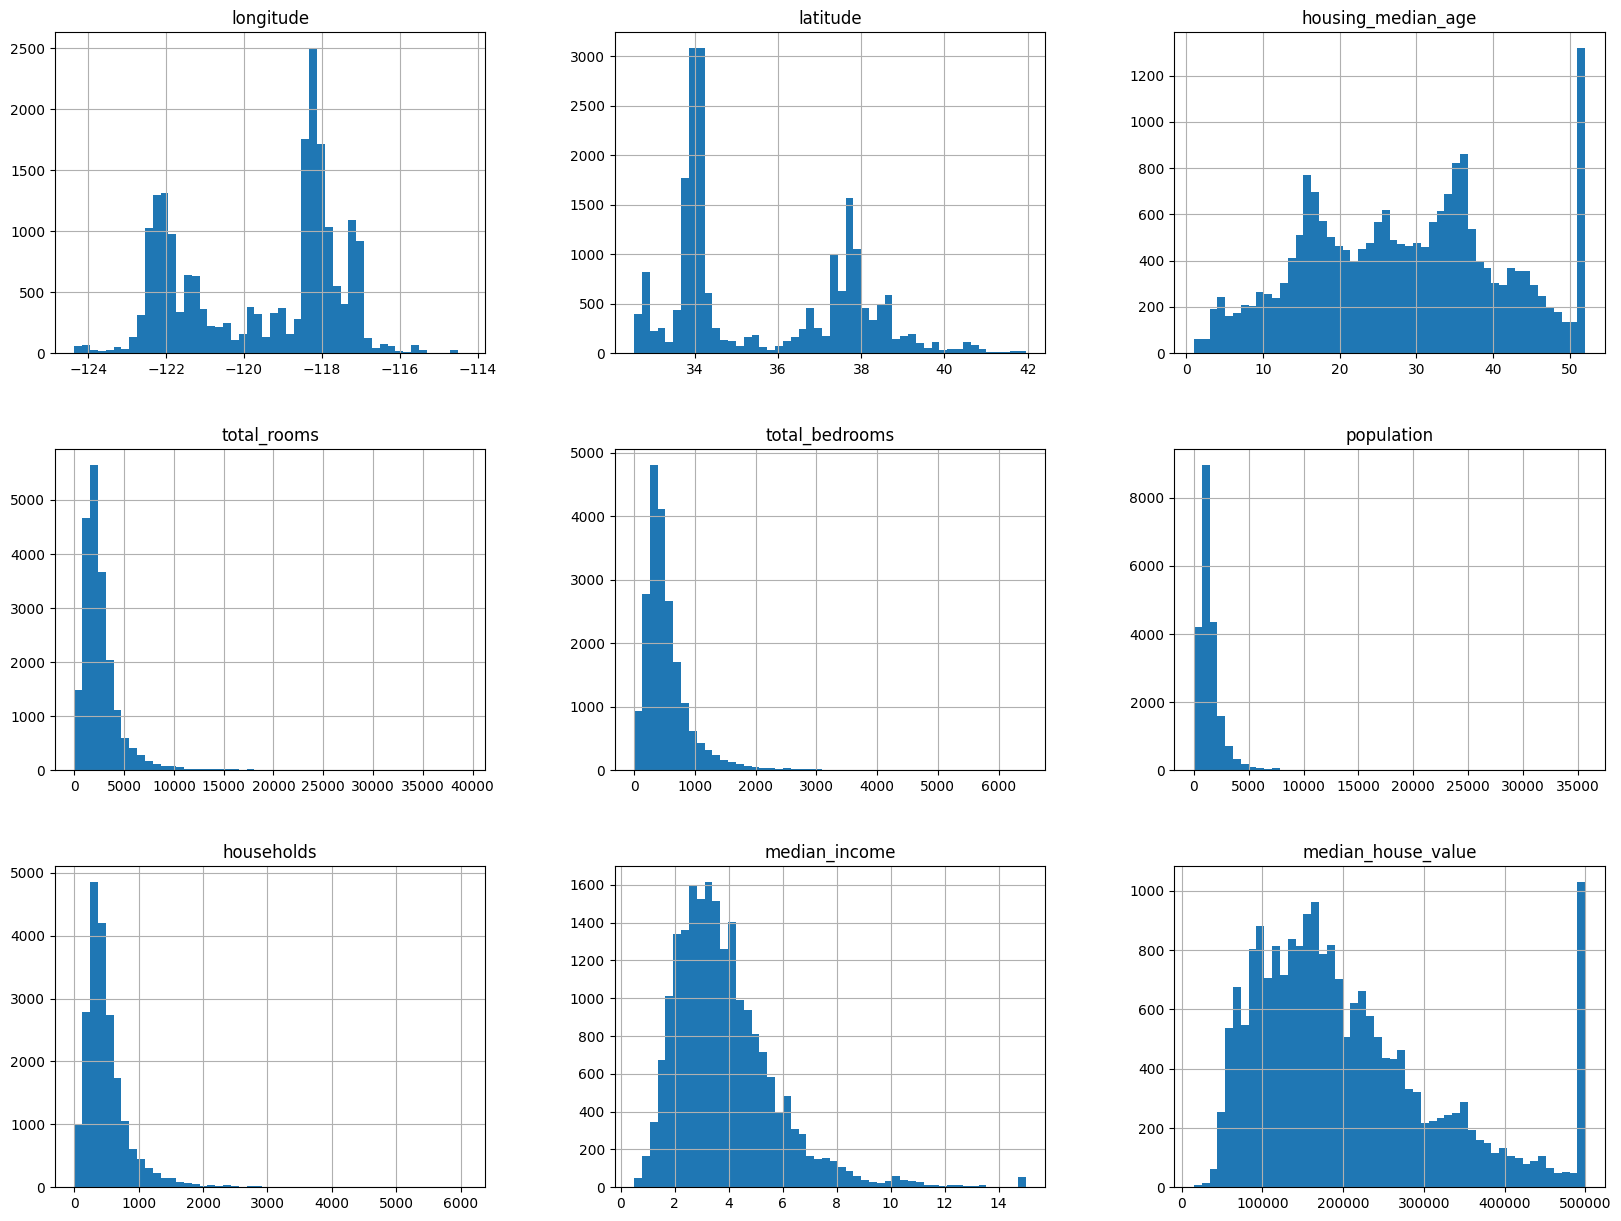

In [12]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

Alguns fatores indicam que teremos dificuldades em encontrar padrões nos dados,
- Os atributos têm escalas muito diferentes
- Os atributos são descritos em 'caudas' e estão deslocados para esquerda ou para direita

# Criando um conjunto de dados de teste

Criar um conjunto de testes é fácil. Selecionamos aleatoriamente **(ou não, se estivermos lidando com séries temporais)** um subconjunto dos dados, normalmente 20% (ou menos, se o conjunto de dados for grande).


In [13]:
def split_train_test(data, test_ratio):   
    '''
    Splits a dataset into train/test using a `test_ratio`.
    
    Arguments:
        data, pd.DataFrame: the whole dataset.
        test_ratio, float: the percentage taken from the original dataset as a test set.
    
    Returns:
        train, pd.DataFrame: the training set.
        test, pd.DataFrame: the test set.
    '''    
    
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [14]:
train_set, test_set = split_train_test(housing, 0.2)

print(' \n train_set: {} \n test_set: {} \n fraction: {:.2f}'.format(len(train_set), len(test_set), len(test_set)/len(housing)))

 
 train_set: 16512 
 test_set: 4128 
 fraction: 0.20


Porém, há um problema: se executarmos o programa novamente, ele gerará um conjunto de teste diferente. Com o tempo, nosso algoritmo de aprendizado de máquina verá todo o conjunto de dados. Que é algo que queremos evitar, conjuntos de teste são criados para serem escondidos do algoritmo/seu globo ocular até que você termine de modelar. Existem 2 soluções possíveis para este problema:

- Salve o conjunto de teste na primeira execução.
- Defina o **random seed** de executar np.random.permutation, dessa forma você está controlando a aleatoriedade de numpy.
Mas ambas as soluções serão interrompidas na próxima vez que carregarmos um conjunto de dados atualizado . Para ter um conjunto de treinamento/teste estável, uma solução comum é usar o identificador de cada instância para decidir se ele deve ser incluído no conjunto de teste ou não. Supondo que as instâncias tenham um identificador único e mutável.

Por exemplo, podemos calcular um hash* com base no identificador de cada instância e permitir apenas (para o conjunto de teste) hashes inferiores a 20% do valor máximo de hash. Esta estratégia é:

- Escalável: sempre teremos 20% dos dados no conjunto de teste.
- Extensível: quando temos um conjunto de dados maior, basta adicionar novas instâncias ao conjunto de teste, ambos os conjuntos são estáveis.

 ***hash - pedaço dos dados**

Aqui está uma implementação possível,

In [15]:
from zlib import crc32


In [16]:
def test_set_check(identifier, test_ratio=.2):
    '''
    Checks if an instance with `identifier` should be in the test set of overall ratio `test_ratio`
    
    Arguments:
        identifier, int: the instance/row identifier (ex. row index from `pd.DataFrame`)
        test_ratio, float \in [0,1]: percentage of test set taken from overall data set.
    
    Returns:
        in_test, bool: True if instance should be in the test set, False otherwise.
    
    Notes:
        - The CRC32 function converts a varibale-length string into an 8-character string that 
        is a text representation of the hexadecimal value of a 32bit binary sequence.
    '''
    
    total_size = 2**32
    hex_repr = crc32(np.int64(identifier)) & 0xffffffff
    in_test = hex_repr < (test_ratio * total_size)
    return in_test

In [17]:
[test_set_check(i) for i in range(10)]


[False, False, True, False, False, True, False, False, False, False]

In [18]:
def split_train_test_by_id(data, test_ratio, id_column):
    '''
    Splits a dataframe using hash-based identification
    
    Arguments:
        data, pd.DataFrame: the dataframe comprised of an id column and data of interest.
        test_ratio, float \in [0,1]: percentage of test set taken from overall data set.
        id_column, string: column name with identifiers for each row.
    
    Returns:
        train, pd.DataFrame: the train set.
        test, pd.DataFrame: the test set.
    '''
    
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [19]:
housing_with_id = housing.reset_index()


In [20]:
train_set, test_set = split_train_test_by_id(data=housing_with_id, test_ratio=0.2, id_column="index")
train_set.shape, test_set.shape

((16512, 11), (4128, 11))

In [21]:
housing.groupby(by=['longitude', 'latitude']).count()['total_rooms'].sort_values()


longitude  latitude
-124.35    40.54        1
-118.90    34.41        1
           35.26        1
           35.41        1
-118.89    34.22        1
                       ..
-122.41    37.75       10
-122.42    37.75       10
-122.44    37.78       11
-122.42    37.80       11
-122.41    37.80       15
Name: total_rooms, Length: 12590, dtype: int64

In [22]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]


In [23]:
train_set, test_set = split_train_test_by_id(data=housing_with_id, test_ratio=0.2, id_column='id')
print(' \n train_set: {} \n test_set: {} \n fraction: {:.2f}'.format(len(train_set), len(test_set), len(test_set)/len(housing)))

 
 train_set: 16322 
 test_set: 4318 
 fraction: 0.21


In [24]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(' \n train_set: {} \n test_set: {} \n fraction: {:.2f}'.format(len(train_set), len(test_set), len(test_set)/len(housing)))

 
 train_set: 16512 
 test_set: 4128 
 fraction: 0.20


Até agora, consideramos apenas métodos de amostragem puramente aleatórios. Isso geralmente é bom se nosso conjunto de dados for grande o suficiente. Se não for, no entanto, corremos o risco de introduzir um viés de amostragem significativo.


Quando uma empresa de pesquisa planeja entrevistar $1000$ pessoas, ela não as escolhe aleatoriamente em uma lista telefônica. Eles garantem que as $1000$ pessoas selecionadas sejam representativas de toda a população-alvo. isso é chamado de amostragem estratificada.


A população é dividida em subgrupos homogêneos chamados estratos. Cada estrato representa uma porcentagem de instâncias da população geral. Queremos um conjunto de testes para manter as porcentagens de cada estrato para garantir que seja representativo de toda a população. Um método de amostragem puramente aleatório introduziu vieses a favor de grupos/estratos dominantes.


Suponha que tenhamos conversado com especialistas que nos disseram que o *median_income* é um recurso muito importante para prever *median_house_value*. Podemos querer garantir que o conjunto de teste seja representativo da *median income*, que pode ser dividida em categorias.


A maioria dos valores de renda mediana estão agrupados em torno de $ $15.000 $ para $ $60.000 $ mas algumas rendas medianas vão muito além $6K$.
É importante ter, para cada estrato, um número suficiente de instâncias em seu conjunto de dados. Ou então, pode haver um viés ao avaliar a importância do estrato.


Vamos usar **pd.cut()** para criar os estratos,

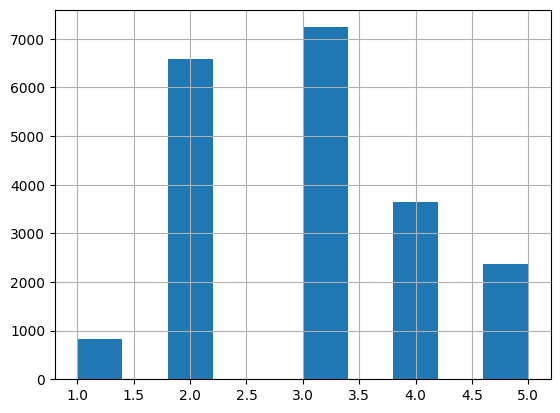

In [25]:
# create the strata
housing['income_cat'] = pd.cut(housing['median_income'],
                        bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                        labels=[1, 2, 3, 4, 5])

housing['income_cat'].hist()

plt.show()

Agora estamos prontos para fazer amostragem estratificada com base na categoria de renda,


In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [27]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [28]:
housing['income_cat'].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Repare que a diferença dos dados de teste para os dados originais estão apenas na terceira casa decimal, ou seja os dados de teste representam bem os dados originais.

In [29]:
# droping the strata
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

# Visualizando dados geográficos

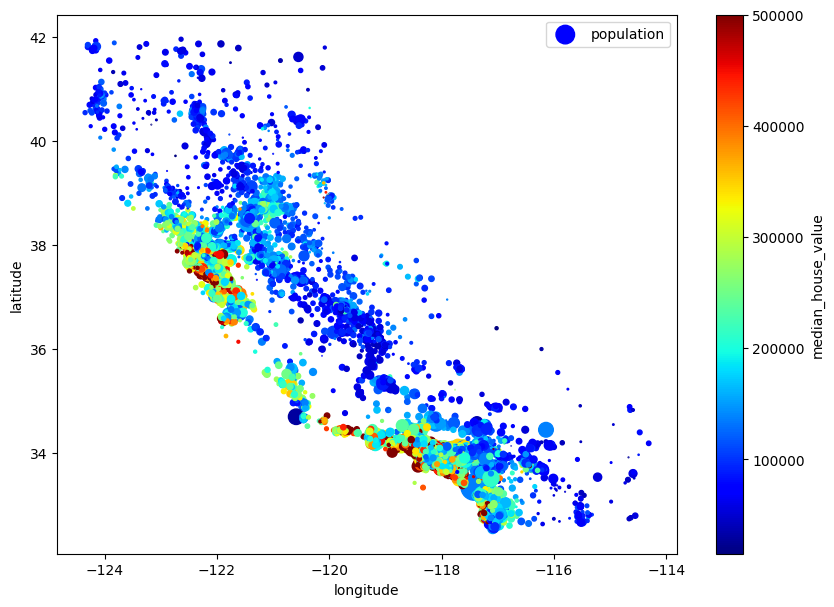

In [30]:
housing = strat_train_set.copy()

housing.plot(kind='scatter', x='longitude', y='latitude',
             s=housing['population']/100,
             label='population',
             figsize=(10, 7),
             c='median_house_value',
             cmap=plt.get_cmap('jet'),
             colorbar=True
             )

plt.show()


In [31]:
housing[['population', 'median_house_value']].corr()


,population,median_house_value
population,1.000000,-0.026882
median_house_value,-0.026882,1.000000


# Buscando correlações

O coeficiente de correlação é, $\epsilon$ [-1, 1]. Quando o coeficiente está próximo de 1, significa que existe uma forte correlação positiva entre as duas variáveis (por exemplo, o valor médio da casa tende a subir à medida que o rendimento médio aumenta). Quando o coeficiente está próximo de -1 significa que existe uma forte correlação negativa entre as duas variáveis. Quando o coeficiente está próximo de 0 significa que existe uma correlação fraca entre as duas variáveis.

In [32]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


In [33]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Outra maneira de ver as correlações é usar o *.scatter_matrix()*, do método Pandas para visualizar as correlações entre quaisquer 2 atributos. Como temos 11 atributos e não cabemos em todos os plots, vamos nos concentrar nos poucos promissores.

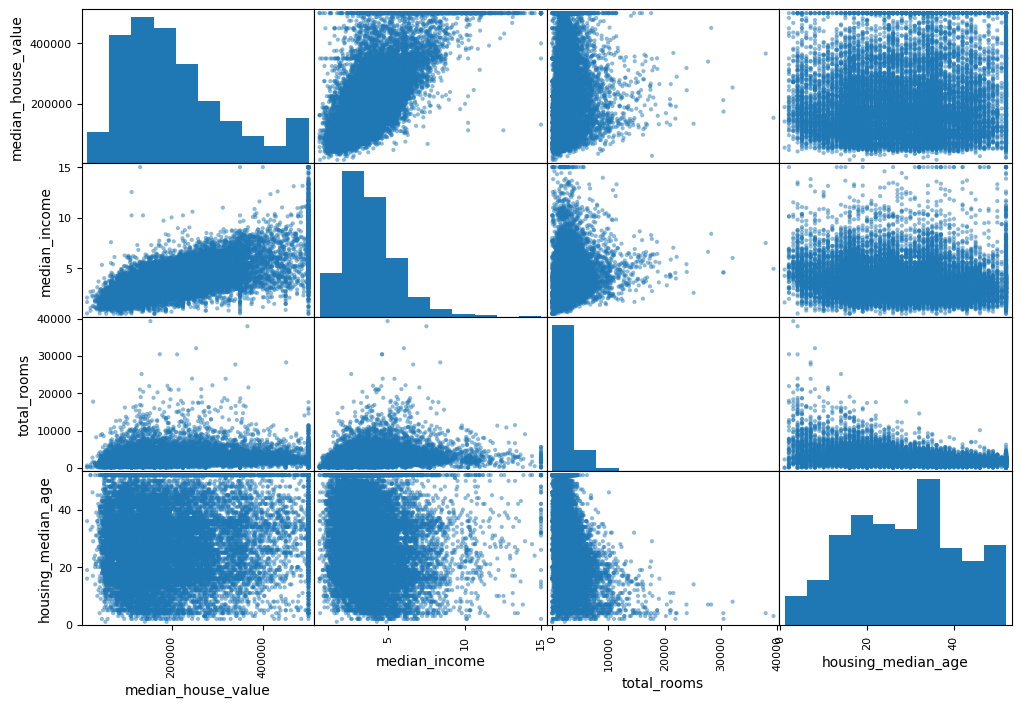

In [34]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()


Existe uma forte correlação entre median_house_value e median_income, vamos ampliar o gráfico em questão,

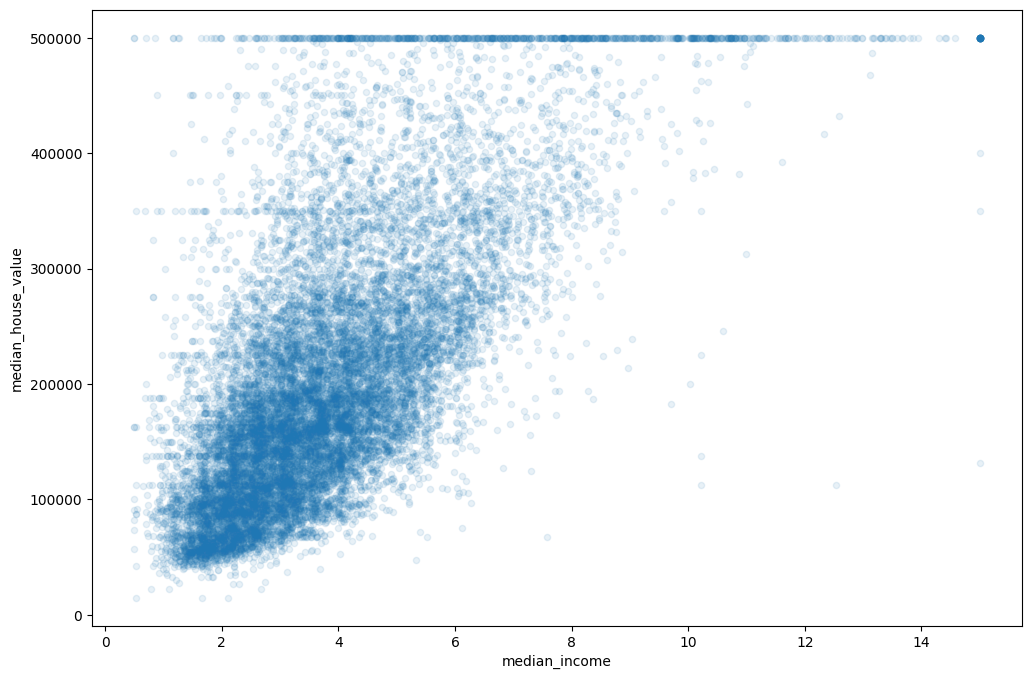

In [35]:
housing.plot(kind='scatter',
             x='median_income',
             y='median_house_value',
             alpha=0.1,
             figsize=(12, 8)
             )

plt.show()

Existe um limite claro em 500k, e outras possíveis linhas que podem atrapalhar a correlação principal. Podemos querer remover essas 'linhas', para que o modelo não aprenda essas peculiaridades.


# Testando combinações de correlações

Uma última coisa que gostaríamos de fazer antes de alimentar os dados em um algoritmo de ML é tentar combinar recursos. Exemplos:
- O número de cômodos por domicílio, não o número total de cômodos em um distrito.
- O número total de quartos também não ajuda, queremos compará-lo com o número de quartos.
- O número de pessoas por família também é uma característica interessante de se observar.


Vamos criar todos eles:


In [36]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [37]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

# Preparando os dados

Em vez de fazer isso manualmente, devemos escrever funções para esse fim. Mencionamos os seguintes motivos:

- Isso nos permitirá reproduzir as transformações em qualquer novo conjunto de dados.
- Construiremos gradualmente uma biblioteca de transformações que podemos usar em projetos futuros.
- Podemos usar essas funções em nossos sistemas ativos para transformar os dados usando um pipeline antes de alimentá-los no algoritmo.
- Isso nos permitirá experimentar várias transformações ou uma combinação delas para verificar o que funciona melhor.

Vamos começar com um novo conjunto de dados novamente:

In [38]:
# setting data
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()
print('\n Dados de treino: {} \n Dados resposta: {}'.format(housing.shape, housing_labels.shape))



 Dados de treino: (16512, 9) 
 Dados resposta: (16512,)


# Limpando os dados

A maioria dos algoritmos de aprendizado de máquina não consegue lidar com recursos ausentes, então vamos criar algumas funções para lidar com eles.

Vimos anteriormente que total_bedroomsfaltam valores, temos 3 opções:

- Livre-se dos distritos correspondentes
- Livre-se de todo o atributo (recurso)
- Defina os valores ausentes para algum valor (zero, média, mediana, regressor preds,...)




In [39]:
housing.drop('total_bedrooms', axis=1)     # 1
median = housing['total_bedrooms']         # 2
housing['total_bedrooms'].fillna(median,   # 3 
                                        inplace=True)

housing.head(10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
1481,-122.04,37.96,28.0,1207.0,252.0,724.0,252.0,3.6964,NEAR BAY
18125,-122.03,37.33,23.0,4221.0,671.0,1782.0,641.0,7.4863,<1H OCEAN
5830,-118.31,34.20,36.0,1692.0,263.0,778.0,278.0,5.0865,<1H OCEAN
17989,-121.95,37.27,17.0,1330.0,271.0,408.0,258.0,1.7171,<1H OCEAN
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,<1H OCEAN


Também podemos usar scikit-learn's SimpleImputer:

In [40]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

housing_num = housing.drop('ocean_proximity', axis=1)

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [41]:
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X,
                          columns=housing_num.columns,
                          index=housing_num.index)

housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


# Manipulando textos e atributos categóricos

In [42]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)


,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [43]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [44]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [45]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [46]:
housing_cat_1hot.toarray()


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [47]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# Customizando as Transformações

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
    
    '''Classe responsavel por add atributos'''
            
    def __init__(self, add_badrooms_per_room=True):
        
        self.add_badrooms_per_room = add_badrooms_per_room
        
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None):
        
        
        room_per_household = X[:, rooms_ix]/X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_badrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, room_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, room_per_household, population_per_household]
        

In [49]:
attr_adder = CombinedAttributesAdder(add_badrooms_per_room=False)
housung_extra_attribs = attr_adder.transform(housing.values)
housung_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

# Escalonamentos das Caracteristicas

Com poucas exceções, os algoritmos de ML não funcionam bem em recursos de dados com escalas diferentes. No entanto, dimensionar o valor de destino geralmente não é necessário.

Existem duas maneiras de fazer com que todos os recursos tenham a mesma escala:

- Min-Max escala: para cada valor, subtraímos por min e dividimos por (max - min).
- Padronização: Para cada valor, subtraímos a média e dividimos pelo seu desvio padrão.

A padronização produz valores com **média 0 e desvio padrão de 1**. Ao contrário da escala Min-Max, a padronização não limita os valores a um intervalo específico. Isso pode causar problemas para alguns algoritmos de ML (Exemplo: NNs geralmente esperam que as entradas variem de 0 a 1). No entanto, a padronização é muito menos afetada por outliers.

Como acontece com todos os transformadores, **é importante ajustar apenas os dados de treinamento, não o conjunto de dados completo**.

# Transformações de Pipelines

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())])             
                
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr.shape

(16512, 11)

In [51]:
from sklearn.compose import ColumnTransformer


num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
    ])



In [52]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

In [53]:
import joblib

joblib.dump(full_pipeline, 'final_pipeline.pkl')

['final_pipeline.pkl']

# Treinando e avaliando o conjunto de treinamento

### Regreção Linear

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [55]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)


In [56]:
print('Predictions: {}'.format(lin_reg.predict(some_data_prepared)))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [57]:
print('Labels: {}'.format(list(some_labels)))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [58]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
linrmse = np.sqrt(lin_mse)
print('Mean squared error (linear mode): {}'.format(linrmse))

Mean squared error (linear mode): 68627.87390018745


In [59]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

print('Mean squared error (decision mode): {}'.format(tree_rmse))

Mean squared error (decision mode): 0.0


# Validação cruzada

In [60]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg,
                         housing_prepared,
                         housing_labels,
                         scoring='neg_mean_squared_error',
                         cv=10
                         )

display_scores = np.sqrt(-scores)

In [61]:
scores.mean()

-5179810100.589704

In [62]:
def display_scores(scores):
    '''
    Displays the scores, their mean, and the standard deviation.
    
    Arguments:
        scores, np.array: list of scores given by the cross validation procedure.
    '''
    
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    

In [63]:
display_scores(scores)

Scores: [-5.32586538e+09 -5.26413059e+09 -4.63854969e+09 -5.41151533e+09
 -4.67491236e+09 -6.11416249e+09 -5.05422379e+09 -5.67773804e+09
 -4.61904603e+09 -5.01795730e+09]
Mean: -5179810100.589704
Standard Deviation: 459062651.2668691


In [64]:
lin_scores = cross_val_score(lin_reg,
                            housing_prepared,
                            housing_labels,
                            scoring='neg_mean_squared_error',
                            cv=10
                            )

lin_rmse_scores = np.sqrt(-lin_scores)

In [65]:
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard Deviation: 2880.3282098180675


In [66]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

print('Mean squared error (forest mode): {}'.format(forest_rmse))

Mean squared error (forest mode): 18766.24630804865


In [67]:
forest_scores = cross_val_score(forest_reg,
                            housing_prepared,
                            housing_labels,
                            scoring='neg_mean_squared_error',
                            cv=10
                            )

forest_rmse_scores = np.sqrt(-forest_scores)

In [68]:
display_scores(forest_rmse_scores)

Scores: [51276.64995679 48826.39765482 46959.97818035 51827.96160793
 47130.12340667 52153.50216887 52451.58514195 49583.52404612
 48543.49509651 53800.55228367]
Mean: 50255.3769543687
Standard Deviation: 2248.583317734137


# Melhorando os parametros 

In [69]:
from sklearn.model_selection import GridSearchCV


In [70]:
# optimizing parameters

parameter_grid = [
    {'n_estimators': [3, 10, 30],
     'max_features': [2, 4, 6, 8]
     },
    {'bootstrap': [False],
     'n_estimators': [3, 10],
     'max_features': [2, 4, 6, 8]
     }
    ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg,
                           param_grid=parameter_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True
                           )

grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [71]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [72]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [73]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

62636.690894133135 {'max_features': 2, 'n_estimators': 3}
55249.977049011075 {'max_features': 2, 'n_estimators': 10}
52838.53485207385 {'max_features': 2, 'n_estimators': 30}
60328.029653495556 {'max_features': 4, 'n_estimators': 3}
53021.95525431474 {'max_features': 4, 'n_estimators': 10}
50637.014482300474 {'max_features': 4, 'n_estimators': 30}
58917.76179644045 {'max_features': 6, 'n_estimators': 3}
52216.366449972564 {'max_features': 6, 'n_estimators': 10}
49927.999534794755 {'max_features': 6, 'n_estimators': 30}
58812.76368277582 {'max_features': 8, 'n_estimators': 3}
52369.655238933505 {'max_features': 8, 'n_estimators': 10}
50199.77277897144 {'max_features': 8, 'n_estimators': 30}
62969.972870005935 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54244.543842920175 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59206.07778430333 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
52338.886498854576 {'bootstrap': False, 'max_features': 4, 'n_estim

In [74]:
feature_importances = grid_search.best_estimator_.feature_importances_
(feature_importances*100).astype(int)

array([ 7,  6,  4,  1,  1,  1,  1, 31,  6, 10,  7,  0, 15,  0,  0,  0])

In [75]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attributes = cat_encoder.categories_[0].tolist()
attributes = num_attribs + extra_attribs + cat_one_hot_attributes

dict(zip(feature_importances, attributes))

{0.07617621740175627: 'longitude',
 0.06714004100714983: 'latitude',
 0.04353712812864936: 'housing_median_age',
 0.018236761103597638: 'total_rooms',
 0.01649704441832574: 'total_bedrooms',
 0.018260826846277587: 'population',
 0.016507721855274063: 'households',
 0.31725834957540655: 'median_income',
 0.06870974139140201: 'rooms_per_hhold',
 0.10965936328826: 'pop_per_hhold',
 0.07765346286045913: 'bedrooms_per_room',
 0.00893514784923068: '<1H OCEAN',
 0.1542331294831259: 'INLAND',
 7.706281625422928e-05: 'ISLAND',
 0.0029072039723535828: 'NEAR BAY',
 0.004210798002477398: 'NEAR OCEAN'}

# Avalie seu sistema no conjunto de teste

Depois de ajustar o modelo, podemos avaliar o conjunto de testes. Não há nada de especial nesse processo, reproduzimos as mesmas etapas que você usou com os dados de treinamento para comparar o modelo. A grande diferença é que agora vamos usar o método .predict()

In [76]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop(labels='median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X=X_test)

final_predictions = final_model.predict(X=X_test_prepared)

final_mse = mean_squared_error(y_true=y_test, y_pred=final_predictions)

final_rmse = np.sqrt(final_mse)
final_rmse

47564.097351472716

# Salvando o modelo

In [77]:
import joblib

In [78]:
joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']

In [79]:
joblib.dump(full_pipeline, 'final_pipeline.pkl')

['final_pipeline.pkl']

É interessante analisar este resultado dentro de um intervalo de confiança,

In [80]:
from scipy import stats

confidence = .95
squared_errors = (y_test - final_predictions)**2
confidence_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))
print('Intervalo de confiança: {:.2f} - {:.2f}'.format(confidence_interval[0], confidence_interval[1]))

Intervalo de confiança: 45544.49 - 49501.38


In [81]:
print('Porcentagem de erro: {:.2f} % - {:.2f} %'.format((confidence_interval[0]/y_test.mean())*100, (confidence_interval[1]/y_test.mean())*100))

Porcentagem de erro: 22.08 % - 24.00 %
